In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Dict, Tuple
from datetime import datetime, timedelta, time

In [2]:
import random

random.seed(42)
np.random.seed(42)

In [3]:
from dataclasses import dataclass
from datetime import timedelta, datetime
from typing import Tuple, List, Optional, Dict, Any
import bisect

# 1 KNOT = 1 MN / H = 1.852 KM / H

MAX_RADAR_DISTANCE = 100
MIN_THRESHOLD = 4    
MIN_BUF = 5            
DEVIATION_SPEED = 200  
DT = 1/60   
DATE = (2025, 9, 10, 6, 0, 0)     

PROXIMITY_RANGE = [
    ((100, 10_000_000), (300, 500)),
    ((50, 100), (250, 300)),
    ((15, 50), (200, 250)),
    ((5, 15), (150, 200)),
    ((0, 5), (120, 150)),
]

LOWER_BOUNDS = [r[0][0] for r in PROXIMITY_RANGE]  # [100, 50, 15, 5, 0]
UPPER_BOUNDS = [r[0][1] for r in PROXIMITY_RANGE]  # [10_000_000,100,50,15,5]
MAX_SPEEDS  = [r[1][1] for r in PROXIMITY_RANGE]   # [500, 300, 250, 200, 150]
MIN_SPEEDS = [r[1][0] for r in PROXIMITY_RANGE]    # [300, 250, 200, 150, 120]

def update_speed(v, low, high):
    return max(low, min(high, v))

def find_range_idx(x: float) -> int:
    """Returns current distance range index"""
    for i, (dist_range, _) in enumerate(PROXIMITY_RANGE):
        dmin, dmax = dist_range
        if dmin <= x <= dmax:
            return i
        
    if x < 0:
        return len(PROXIMITY_RANGE) - 1
    return 0

def minutes_from_AEP(curr_pos: float, curr_speed: float, curr_range_idx: int) -> float:
    """
    Returns minutes left to arrive at AEP from current position, considering current speed and no congestion
    """
    if curr_pos <= 0:
        return 0

    lower = LOWER_BOUNDS
    upper = UPPER_BOUNDS

    x = curr_pos
    remaining_time = 0 # in hs

    for i in range(len(PROXIMITY_RANGE)):
        high = upper[i]
        low = lower[i+1] if i+1 < len(lower) else 0

        # Longitud del tramo actual [lo, hi] que nos queda por recorrer
        actual_pos = min(x, high)
        lower_bound = low
        segment = max(0.0, actual_pos - lower_bound)
        if segment <= 0:
            continue

        vmax = MAX_SPEEDS[i]

        estimated_speed = min(vmax, curr_speed) if i == curr_range_idx else vmax
        remaining_time += segment / estimated_speed

        x = low
        if x <= 0:
            break

    return remaining_time * 60.0  # minutos

@dataclass
class Plane:
    pos: float = MAX_RADAR_DISTANCE  # MN a AEP
    range_idx: int = 0 # PROXIMITY_RANGE idx
    dist_range: Tuple[int, int] = PROXIMITY_RANGE[0][0]
    speed_range: Tuple[int, int] = PROXIMITY_RANGE[0][1]
    speed: float = PROXIMITY_RANGE[0][1][1]  # knots
    dir: int = -1 # -1 towards AEP, 1 away from AEP
    id: Optional[int] = None
    status: str = "on-time" # on-time | delayed | diverted | landed
    landed: bool = False
    sta: datetime = None  # Scheduled Time of Arrival
    eta: datetime = None  # Estimated Time of Arrival
    ata: datetime = None  # Actual Time of Arrival
    dt: float = DT  # step size
    adjusting_speed: bool = False
    history: List[Tuple[float, float, int, str]] = field(default_factory=list)

    def update_ranges(self):
        """Updates ranges based on current position"""
        idx = find_range_idx(self.pos)
        self.range_idx = idx
        self.dist_range = PROXIMITY_RANGE[idx][0]
        self.speed_range = PROXIMITY_RANGE[idx][1]

        self.speed = update_speed(self.speed, self.speed_range[0], self.speed_range[1])

    def update_eta(self, now: datetime):
        """Updates ETA based on current time"""
        time_left_min = minutes_from_AEP(self.pos, self.speed, self.range_idx)
        self.eta = now + timedelta(minutes=time_left_min)


    def find_gap(self, plane_list: List['Plane']) -> int:
        """
        Returns index where self should be inserted in the plane queue.
        Return value respects 5 min buffer with next and previous plane.
        Returns -1 if no gap was found, -10 if plane is out of bounds
        """
        if self.pos > MAX_RADAR_DISTANCE:
            return -10
        if self.eta is None:
            return -1

        if not plane_list or len(plane_list) == 0:
            # If plane_list is empty and plane is in radar distance, it can be inserted at first pos.
            return 0 if self.pos <= MAX_RADAR_DISTANCE else -1

        etas = [p.eta for p in plane_list]

        # If there are planes with no ETA, the result would be undefined, return -1
        if any(e is None for e in etas): return -1
        # If for some reason ETAs are not ordered, the result is undefined, return -1
        if not all(etas[i] <= etas[i + 1] for i in range(len(etas) - 1)): return -1

        idx = bisect.bisect_left(etas, self.eta)

        delta = timedelta(minutes=MIN_BUF)

        # Check if next plane is 5 mins ahead
        if idx - 1 >= 0:
            if (self.eta - etas[idx - 1]) < delta:
                return -1
        # Check if previous plane is 5 mins behind
        if idx < len(etas):
            if (etas[idx] - self.eta) < delta:
                return -1

        return idx

    @staticmethod
    def calc_eta(x: float, speed: float, rng: int) -> float:
        """Returns estimated time of arrival based on now and minutes from AEP."""
        rng = max(0, min(rng, len(PROXIMITY_RANGE) - 1))
        return minutes_from_AEP(x, speed, rng)

    def tick(self, now: datetime):
        """
        Avanza un tick:
          - Actualiza posición y estado (aterrizado si pos<=0)
          - Recalcula rangos y ETA
          - Actualiza status on-time/delayed según STA si está disponible
        """
        
        # Move
        self.pos += self.speed * self.dt * self.dir
        if self.pos <= 0:
            self.pos = 0
            self.status = "landed"
            self.landed = True
            self.ata = now
            self.eta = now
            return

        # Update ranges and eta
        if self.dir == -1:
            self.update_ranges()
        self.update_eta(now)

        if self.sta is not None and self.eta is not None:
            self.status = "delayed" if self.eta > self.sta else "on-time"
        t0 = datetime(*DATE)  # 2025-09-10 06:00:00
        minutes_since_start = (now - t0).total_seconds() / 60.0
        self.history.append((minutes_since_start, self.pos, self.dir, self.status))

    def update(self, plane_list: List['Plane'], plane_idx: int) -> Dict[str, Any]:
        """
        Lógica de espaciado/velocidad/desvío.
        NO modifica plane_list. Devuelve una acción para aplicar afuera:
          - {"action": "none"|"insert"|"divert", ...}
        """

        if self.landed:
            return {"action": "none", "status": self.status, "idx": -1}

        # Plane is moving away from AEP
        if self.dir == 1:
            idx = self.find_gap(plane_list)
            if idx == -10:
                self.status = "diverted"
                return {"action": "divert", "status": self.status, "idx": -10}
            elif idx == -1:
                return {"action":"none", "status": self.status, "idx": -1} 
            else:
                self.dir = -1
                self.adjusting_speed = False
                self.speed = self.speed_range[1]
                return {"action": "insert", "status": self.status, "idx": idx}

        # Moving towards AEP and self is not first plane
        if 0 < plane_idx < len(plane_list) and plane_list[plane_idx - 1].eta is not None and self.eta is not None:
            next_plane = plane_list[plane_idx - 1]
            time_gap = (self.eta - next_plane.eta).total_seconds() / 60.0

            if time_gap < MIN_THRESHOLD:
                self.adjusting_speed = True

            if self.adjusting_speed:
                if time_gap >= MIN_BUF:
                    self.adjusting_speed = False
                    self.speed = self.speed_range[1]
                else:
                    # keep safety speed until MIN_BUF is achieved
                    self.speed = next_plane.speed - 20
            else:
                # Updte speed to max permitted speed
                self.speed = self.speed_range[1]

            # If self fell out of min speed, 
            if self.speed < self.speed_range[0]:
                self.dir = 1
                self.adjusting_speed = False
                self.speed = DEVIATION_SPEED
                return {"action": "reposition", "status": self.status}

        return {"action": "none", "status": self.status}


In [ ]:
from dataclasses import dataclass
from datetime import datetime, timedelta
from typing import List, Dict, Any, Tuple, Optional
import numpy as np

LAMBDA = 1/60
SIMULATION_TIME = 18 * 60
DATE = (2025, 9, 10, 6, 0, 0)

@dataclass
class Handler:
    n_iters: int = 1  # por si querés correr varias simulaciones y guardar métricas
    arrival_rate: float = 1 / 60

    def create_plane(self, now: datetime) -> 'Plane':
        p = Plane()
        minutes = Plane.calc_eta(p.pos, p.speed, p.range_idx)
        p.sta = now + timedelta(minutes=minutes)
        p.eta = p.sta
        return p

    def sort_incoming(self, incoming_planes: List['Plane']) -> None:
        old_incoming = incoming_planes.copy()
        incoming_planes.sort(key=lambda x: (x.eta is None, x.eta))
        # Sanity check, nunca puede haber un avion "mas adelante" pero atras en la fila
        # assert all(old_incoming[i] == incoming_planes[i] for i in range(len(old_incoming)))

    def simulate(self) -> Dict[str, Any]:
        results: Dict[str, Any] = {
            "simulations": []
        }

        for sim in range(self.n_iters):
            now = datetime(*DATE)
            all_planes: List[Plane] = []
            incoming_planes: List[Plane] = []
            repositioning_planes: List[Plane] = []

            landed_count = 0
            diverted_count = 0
            reposition_count = 0

            for t in range(SIMULATION_TIME):

                if np.random.uniform(0, 1) <= self.arrival_rate:
                    p = self.create_plane(now)
                    all_planes.append(p)
                    incoming_planes.append(p)

                for p in all_planes:
                    if (not p.landed) and (p.status != "diverted"): # only on-air planes are updated
                        p.tick(now)

                # Sanity check
                self.sort_incoming(incoming_planes)

                i = 0
                while i < len(incoming_planes):
                    p = incoming_planes[i]

                    if p.landed or p.status == "landed":
                        landed_count += 1
                        incoming_planes.pop(i)
                        # no update i bc removed element
                        continue

                    res = p.update(incoming_planes, i)
                    action = res.get("action", "none")

                    if action == "reposition": # plane has moved to repositioning queue
                        reposition_count += 1
                        repositioning_planes.append(p)
                        incoming_planes.pop(i)
                        # no update i bc removed element
                        continue

                    if action == "divert":
                        diverted_count += 1
                        incoming_planes.pop(i)
                        # no update i bc removed element
                        continue

                    i += 1

                j = 0
                while j < len(repositioning_planes):
                    p = repositioning_planes[j]
                    res = p.update(incoming_planes, -1)
                    action = res.get("action", "none")

                    if action == "insert":
                        idx = res.get("idx", None)
                        if idx is not None and idx >= 0:
                            if idx > len(incoming_planes):
                                idx = len(incoming_planes)
                            incoming_planes.insert(idx, p)
                            repositioning_planes.pop(j)
                        self.sort_incoming(incoming_planes) # Sanity check
                        # no update j bc removed element
                        continue

                    if action == "divert":
                        diverted_count += 1
                        repositioning_planes.pop(j)
                        # no update j bc removed element
                        continue

                    j += 1

                now += timedelta(minutes=1)

            results["simulations"].append({
                "simulation_id": sim,
                "landed": landed_count,
                "diverted": diverted_count,
                "reposition_count": reposition_count,
                "total_planes": len(all_planes)
            })

        return results, all_planes

In [31]:
from tqdm import tqdm
rate = np.linspace(1/60, 1, 100)
mean_planes = []
mean_landings = []
mean_diversions = []
mean_reposition = []
std_planes = []
std_landings = []
std_diversions = []
std_reposition = []

for r in tqdm(rate, desc="Simulation:"):
    h = Handler(1000)
    results, _ = h.simulate()
    df = pd.DataFrame.from_records(results["simulations"])
    mean_planes.append(df["total_planes"].mean())
    mean_landings.append(df["landed"].mean())
    mean_diversions.append(df["diverted"].mean())
    mean_reposition.append(df["reposition_count"].mean())

    std_planes.append(df["total_planes"].std())
    std_landings.append(df["landed"].std())
    std_diversions.append(df["diverted"].std())
    std_reposition.append(df["reposition_count"].std())

Simulation:: 100%|██████████| 100/100 [11:05<00:00,  6.66s/it]


In [32]:
simulations = {"mean_planes":mean_planes, "std_planes":std_planes,
               "mean_diversions":mean_diversions, "std_diversions":std_diversions,
               "mean_landings":mean_landings, "std_landings":std_landings,
               "mean_reposition":mean_reposition, "std_reposition":std_reposition}
df = pd.DataFrame.from_dict(simulations)
df

,mean_planes,std_planes,mean_diversions,std_diversions,mean_landings,std_landings,mean_reposition,std_reposition
0,18.019,4.302691,0.002,0.044699,17.622,4.259490,2.773,2.368350
1,17.845,4.284546,0.000,0.000000,17.504,4.222062,2.712,2.457864
2,17.969,4.145024,0.001,0.031623,17.611,4.094685,2.656,2.286677
3,17.809,4.078867,0.001,0.031623,17.451,4.026389,2.719,2.381535
4,18.069,4.196886,0.001,0.031623,17.692,4.118993,2.692,2.504278
...,...,...,...,...,...,...,...,...
95,18.011,4.076211,0.001,0.031623,17.641,4.034401,2.735,2.465533
96,18.234,4.225766,0.001,0.031623,17.836,4.168030,2.918,2.542389
97,18.273,4.136373,0.001,0.031623,17.909,4.065864,2.741,2.425242
98,18.011,4.066868,0.001,0.031623,17.643,4.003196,2.697,2.340656


In [2]:
df = pd.read_csv("simulation_example.csv")

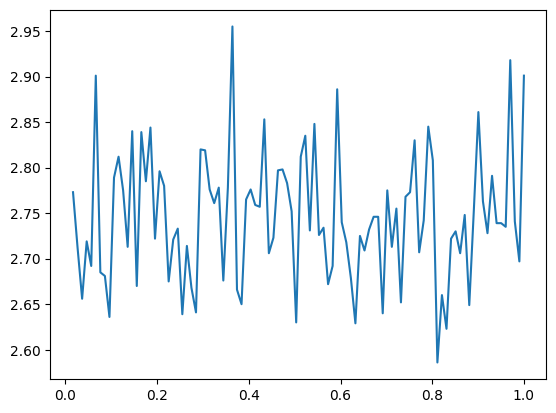

In [8]:
rate = np.linspace(1/60, 1, 100)
plt.plot(rate, df["mean_reposition"])
plt.show()